In [1]:
import helper
import scipy.io as scio
import os
from nufft_cpu import NUFFT_cpu
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
gray = cm.gray
from matplotlib.ticker import FuncFormatter
import tensorflow as tf
import seaborn as sns
# sns.set_style('whitegrid')
import time
import datetime

In [2]:
import cv2

In [3]:
def fake_Cartesian(Nd):
    dim = len(Nd) # dimension
    M = np.prod(Nd)
    om = np.zeros((M, dim), dtype = np.float)
    grid = np.indices(Nd)
    for dimid in range(0, dim):
        om[:, dimid] = (grid[dimid].ravel() *2/ Nd[dimid] - 1.0)*np.pi
    return om

In [4]:
Nd = (48,48,30)  # time grid, tuple
Kd = (100,100,100)  # frequency grid, tuple
Jd = (3,3,3)  # interpolator

DATA_PATH = '/Users/yan/Documents/document/EPFL/thesis/codes/3dgridding/pynufft-master/src/data/'

image = np.load(DATA_PATH + 'phantom_3D_128_128_128.npz')['arr_0']

# image = cv2.resize(image,(48,48,30),interpolation = cv2.INTER_AREA)
image = cv2.resize(image,(48,48))
image = image[:,:,::4]
image = image[:,:,:-2]

folder_path = r'/Users/yan/Documents/document/EPFL/thesis/codes/3dgridding/testing/'
# trajectory = scio.loadmat(os.path.join(folder_path, '3D_traj.mat'))['traj']
trajectory = scio.loadmat(os.path.join(folder_path, 'test_full_spiral.mat'))['test']
om = trajectory['k'][0][0]

# om = fake_Cartesian(Nd)

# om = np.random.randn(15120,3)

om = om / om.max() * 3  # normalized between (-pi,pi)

In [8]:
48*48*30

69120

In [10]:
np.reshape(image,Kd,order='C')

ValueError: cannot reshape array of size 69120 into shape (100,100,100)

In [5]:
om.shape

(24317, 3)

In [6]:
om.min(),om.max() # always check the range of k

(-2.9890969244125847, 3.0)

In [7]:
NufftObj = NUFFT_cpu()
start = datetime.datetime.now()
NufftObj.plan(om, Nd, Kd, Jd) # 4 seconds, mainly for calculating all the matrix needed for the min-max algorithm
end0 = datetime.datetime.now()
kspace = NufftObj.forward(image) # non-gridded ksp
end1 = datetime.datetime.now()
restore_image1 = NufftObj.solve(kspace, 'cg', maxiter=200)
end2 = datetime.datetime.now()
adj_img = NufftObj.adjoint(kspace)
end3 = datetime.datetime.now()
# # restore_image2 = NufftObj.solve(kspace, 'L1TVOLS', maxiter=200, rho=0.1)

print((end0-start).seconds,(end1-end0).seconds, (end2-end1).seconds, (end3-end2).seconds)

InvalidArgumentError: Input to reshape is a tensor with 69120 values, but the requested shape has 1000000 [Op:Reshape]

In [8]:
end1 - start

datetime.timedelta(seconds=6, microseconds=693767)

In [9]:
start

datetime.datetime(2020, 5, 22, 9, 20, 6, 170615)

In [10]:
def formatnum(x, pos):
    return '$%.1f$x$10^{5}$' % (x/100000)
formatter = FuncFormatter(formatnum)

In [27]:
def plotImage(org,cg,adjoint,Nmid):
    plt_x = 4
    plt_y = 3
    plt.figure(figsize=(20,24))
    title = "image cut from z axis at slice %s"%Nmid
    plt.suptitle(title,fontsize=16,y=0.83)
    ax = plt.subplot(plt_x,plt_y,1)
    plt.subplots_adjust(top=0.8)
    ax.imshow(org, label='original', cmap=gray)
    plt.axis('off')
    plt.title('original image')
    ax = plt.subplot(plt_x,plt_y,2)
#     plt.imshow(tf.math.real(cg), label='CG', cmap=gray)
    plt.imshow(abs(cg), label='CG', cmap=gray)
#     dif = tf.math.real(cg).numpy()-org.numpy()
    dif = abs(cg).numpy()-org.numpy()
    dif = np.sum(abs(dif))/(cg.shape[0]*cg.shape[1])
    plt.axis('off')
    plt.title('cg with abs error %.3f'%dif)
    ax = plt.subplot(plt_x,plt_y,3)
    plt.imshow(tf.math.real(adjoint), label='adjoint', cmap=gray)
#     dif = tf.math.real(adjoint).numpy()-org.numpy()
    dif = abs(adjoint).numpy()-org.numpy()
    dif = np.sum(abs(dif))/(cg.shape[0]*cg.shape[1])
    plt.axis('off')
    plt.title('adjoint with abs error %.3f'%dif)

    ax = plt.subplot(plt_x,plt_y,4)
    ax.plot(sum(abs(org)))
#     ax.yaxis.set_major_formatter(formatter)
    plt.title('projection on x axis')
    ax = plt.subplot(plt_x,plt_y, 5)
#     ax.plot(sum((tf.math.real(cg))))
    ax.plot(sum((abs(cg))))
#     ax.yaxis.set_major_formatter(formatter)
    plt.title('projection on x axis')
    ax = plt.subplot(plt_x,plt_y, 6)
#     ax.plot(sum((tf.math.real(adjoint))))
    ax.plot(sum((abs(adjoint))))
#     ax.yaxis.set_major_formatter(formatter)
    plt.title('projection on x axis')

    plt.subplot(plt_x,plt_y,7)
    plt.imshow(tf.math.imag(org), label='original', cmap=gray)
    plt.axis('off')
    plt.title('original image.imag')
    plt.subplot(plt_x,plt_y,8)
    plt.imshow(tf.math.imag(cg), label='CG', cmap=gray)
    plt.title('cg.imag')
    plt.axis('off')
    plt.subplot(plt_x,plt_y,9)
    plt.imshow(tf.math.imag(adjoint), label='adjoint', cmap=gray)
    plt.title('adjoint.imag')
    plt.axis('off')

    ax = plt.subplot(plt_x,plt_y,10)
    ax.plot(sum(tf.math.imag(org)))
    plt.title('projection on x axis')
    ax = plt.subplot(plt_x,plt_y, 11)
    ax.plot(sum((tf.math.imag(cg))))
    plt.title('projection on x axis')
#     ax.yaxis.set_major_formatter(formatter)
    ax = plt.subplot(plt_x,plt_y, 12)
    ax.plot(sum((tf.math.imag(adjoint))))
    plt.title('projection on x axis')
#     ax.yaxis.set_major_formatter(formatter)
    
#     org = tf.cast(org,tf.complex64)
#     gridded_k = tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(org)))
#     plt.subplot(plt_x,plt_y,13)
#     magnitude = abs(org)
#     ind = np.unravel_index(np.argmax(magnitude, axis=None), gridded_k.shape)
#     plt.imshow(magnitude,cmap=gray)
#     plt.title('Magnitude')
    
#     plt.subplot(plt_x,plt_y,16)
#     phase = tf.math.angle(org)
#     plt.imshow(phase,cmap=gray)
#     ind = np.unravel_index(np.argmax(phase, axis=None), gridded_k.shape)
#     plt.title('org Phase')

#     gridded_k = tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(cg)))
#     plt.subplot(plt_x,plt_y,14)
#     magnitude = abs(cg)
#     ind = np.unravel_index(np.argmax(magnitude, axis=None), gridded_k.shape)
#     plt.imshow(magnitude,cmap=gray)
#     plt.title('Magnitude')
    
#     plt.subplot(plt_x,plt_y,17)
#     phase = tf.math.angle(cg)
#     plt.imshow(phase,cmap=gray)
#     ind = np.unravel_index(np.argmax(phase, axis=None), gridded_k.shape)
#     plt.title('cg Phase')
    
#     gridded_k = tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(adjoint)))
#     plt.subplot(plt_x,plt_y,15)
#     magnitude = abs(adjoint)
#     ind = np.unravel_index(np.argmax(magnitude, axis=None), gridded_k.shape)
#     plt.imshow(magnitude,cmap=gray)
#     plt.title('Magnitude')
    
#     plt.subplot(plt_x,plt_y,18)
#     phase = tf.math.angle(adjoint)
#     plt.imshow(phase,cmap=gray)
#     ind = np.unravel_index(np.argmax(phase, axis=None), gridded_k.shape)
#     plt.title('adjoint Phase')

#     plt.savefig(title+'.jpg')
    plt.show()

In [12]:
image.shape

(48, 48, 30)

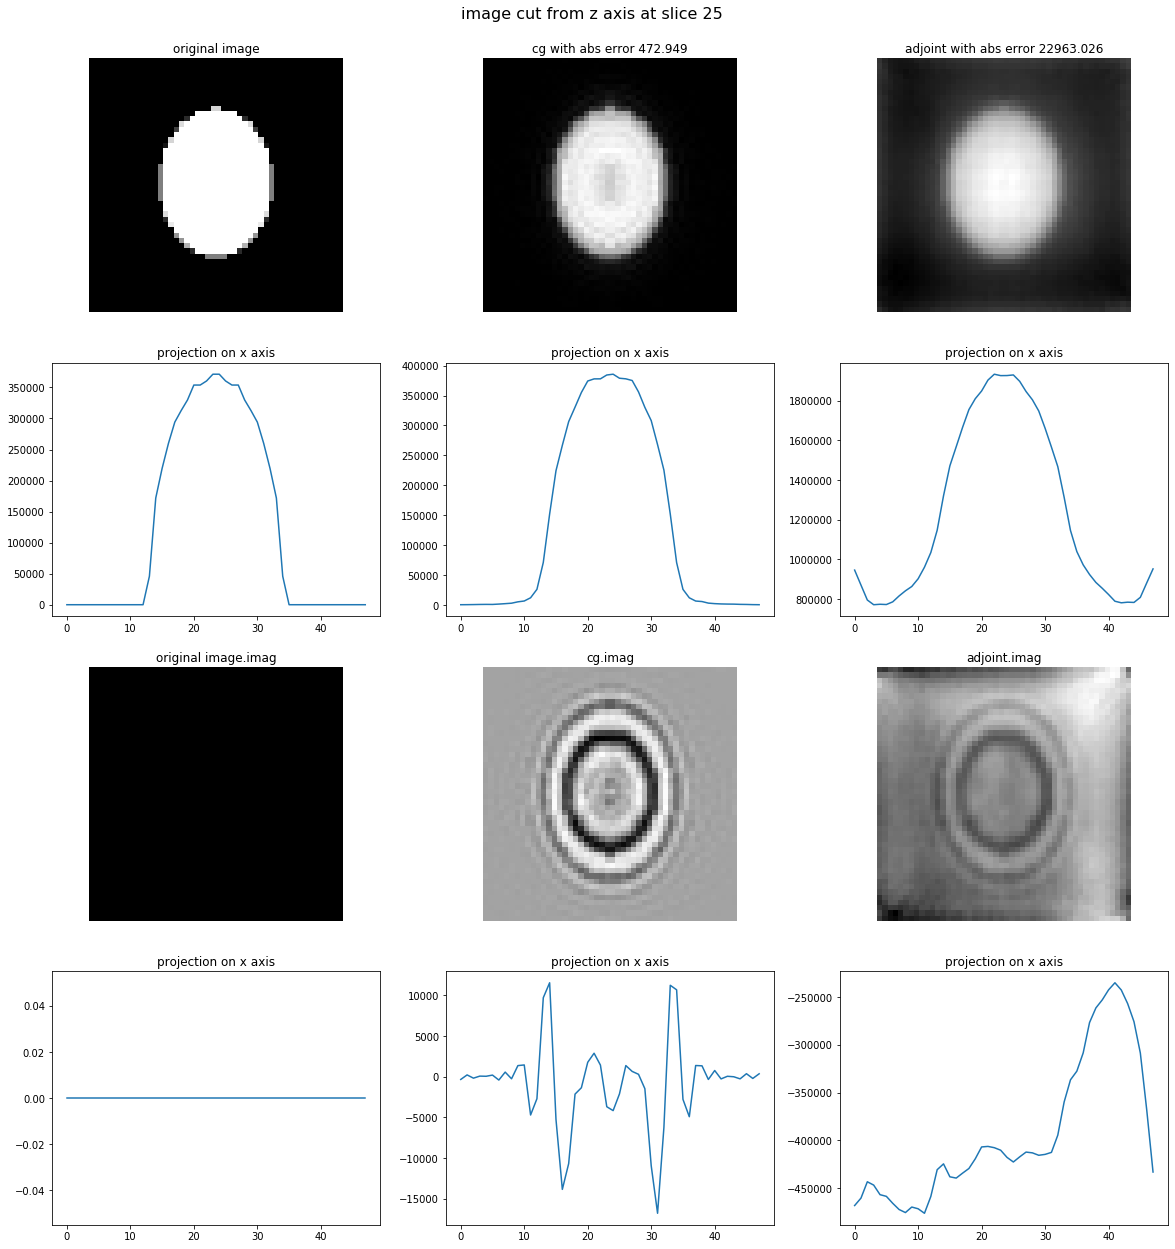

In [31]:
image = tf.cast(image, tf.int64)
Nmid = int(25)
plotImage(image[:,:,Nmid],restore_image1[:,:,Nmid],adj_img[:,:,Nmid],Nmid)

In [14]:
om = fake_Cartesian((63,63,63))

In [15]:
import numpy
import matplotlib.pyplot

matplotlib.pyplot.gray()

def fake_Cartesian(Nd):
    dim = len(Nd) # dimension
    M = numpy.prod(Nd)
    om = numpy.zeros((M, dim), dtype = numpy.float)
    grid = numpy.indices(Nd)
    for dimid in range(0, dim):
        om[:, dimid] = (grid[dimid].ravel() *2/ Nd[dimid] - 1.0)*numpy.pi
    return om

import scipy.misc
# from pynufft import NUFFT_cpu


Nd = (63,63)
Kd = (126,126)
Jd = (6,6)

# image = scipy.misc.ascent()
# image = image[:,:,32]
# image = image.numpy()
om = fake_Cartesian(Nd)


print('Number of samples (M) = ', om.shape[0])
print('Dimension = ', om.shape[1])
print('Nd = ', Nd)
print('Kd = ', Kd)
print('Jd = ', Jd)

NufftObj = NUFFT_cpu()
NufftObj.plan(om, Nd, Kd, Jd)
kspace = NufftObj.forward(image)

ksp = kspace.reshape(Nd, order='C')
x2 = numpy.fft.ifftshift(numpy.fft.ifftn(numpy.fft.ifftshift(ksp)))

restore_image1 = NufftObj.solve(kspace, 'cg', maxiter=200)
adj_img = NufftObj.adjoint(kspace)

Number of samples (M) =  3969
Dimension =  2
Nd =  (63, 63)
Kd =  (126, 126)
Jd =  (6, 6)


/opt/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow_core/python/framework/constant_op.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


InvalidArgumentError: Incompatible shapes: [48,48,30] vs. [63,63] [Op:Mul] name: mul/

<Figure size 432x288 with 0 Axes>

In [ ]:
from pynufft import NUFFT_cpu
import numpy as np
import os
import scipy.io as scio
import tensorflow as tf
import matplotlib.pyplot as plt
Nd = (63,63,63)  # time grid, tuple
Kd = (63,63,63)  # frequency grid, tuple
Jd = (3,3,3)  # interpolator

DATA_PATH = '/Users/yan/Documents/document/EPFL/thesis/codes/3dgridding/pynufft-master/src/data/'

image = np.load(DATA_PATH + 'phantom_3D_128_128_128.npz')['arr_0'][0::2, 0::2, 0::2][:-1,:-1,:-1]

folder_path = r'/Users/yan/Documents/document/EPFL/thesis/codes/3dgridding/testing/'
# trajectory = scio.loadmat(os.path.join(folder_path, '3D_traj.mat'))['traj']
trajectory = scio.loadmat(os.path.join(folder_path, 'test_full_spiral.mat'))['test']
om = trajectory['k'][0][0]
# om = scio.loadmat(os.path.join(folder_path, 'full_trajectory.mat'))['k']
# om = np.random.randn(15120,3)


om = om / om.max() * 3  # normalized between (-pi,pi)

NufftObj = NUFFT_cpu()
NufftObj.plan(om, Nd, Kd, Jd)
kspace = NufftObj.forward(image) # non-gridded ksp

restore_image1 = NufftObj.solve(kspace, 'cg', maxiter=200)
adj_img = NufftObj.adjoint(kspace)

# kspace = kspace.reshape(Kd, order='C')

In [ ]:
plt.figure(figsize=(10,10))
matplotlib.pyplot.subplot(2,2,1)
matplotlib.pyplot.imshow(image.real,cmap=gray)
matplotlib.pyplot.title('Original image')
matplotlib.pyplot.subplot(2,2,2)
matplotlib.pyplot.imshow(x2.real,cmap=gray)
matplotlib.pyplot.title('ifft image')
matplotlib.pyplot.subplot(2,2,3)
matplotlib.pyplot.imshow(restore_image1.real,cmap=gray)
matplotlib.pyplot.title('cg')
matplotlib.pyplot.subplot(2,2,4)
matplotlib.pyplot.imshow(adj_img.real,cmap=gray)
matplotlib.pyplot.title('adjoint')

matplotlib.pyplot.show()